In [175]:
import pandas as pd
import numpy as np
import scipy
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import signal
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [135]:
data = pd.read_csv("data.csv")

Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж. Описание датасета:

Item_Identifier	Id продукта
Item_Weight	Вес продукта
Item_Fat_Content	Содержание жира в продукте
Item_Visibility	%полок, отведенный под наш продукт в конкретном магазине
Item_Type	Категория продукта
Item_MRP	Максимальная цена продажи продукта
Outlet_Identifier	Идентификатор магазина
Outlet_Establishment_Year	Год открытия магазина
Outlet_Size	Площадь магазина
Outlet_Location_Type	Тип города, в котором расположен магазин
Outlet_Type	Признак является ли магазин продуктовым или супермаркетом
Item_Outlet_Sales	Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

In [136]:
#Удаляем не информативные столбцы
data = data.drop(['Item_Identifier', 'Outlet_Identifier','Outlet_Establishment_Year', 'Outlet_Location_Type'], axis = 1)
data

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,Medium,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,Medium,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,Medium,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,NaN,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,High,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,High,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,NaN,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,Small,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,Medium,Supermarket Type2,1845.5976


In [137]:
#pandas_profiling.ProfileReport(data)

In [138]:
#Пропущенные значения
data.isnull().sum()

Item_Weight          1463
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Size          2410
Outlet_Type             0
Item_Outlet_Sales       0
dtype: int64

In [139]:
#Заменяем пропуски веса продукта на нули 
data.Outlet_Size = data.Outlet_Size.astype(object).fillna(method='ffill')    

In [140]:
# Так как продажи продукта в магазине "Unknown" "похожи" на продажи "Small", то, заменю пропуски этим значением
data_group = data.groupby(by=['Outlet_Size']).agg({'Item_Outlet_Sales':['mean', 'median', 'count']}).reset_index()
data_group

Outlet_Size Item_Outlet_Sales                 
                           mean     median count
0        High       2183.929805  1896.5313  1290
1      Medium       2439.236249  2007.0541  3912
2       Small       1876.411850  1494.0552  3321

In [141]:
#Далее смотрю, как заменить нули. Заменяю медианным значение для каждой группы Item_Type
data_group_not = data.groupby(by=['Item_Type']).agg({'Item_Weight':['mean', 'median', 'sum']})['Item_Weight'].reset_index()
for i in data_group_not.Item_Type:
    a = data_group_not.loc[data_group_not['Item_Type'] == i,'median'].values[0]
    data.loc[data['Item_Type'] == i,'Item_Weight'] = a

In [142]:
data_group_not = data.groupby(by=['Item_Type']).agg({'Item_Weight':['mean', 'count', 'sum'], 'Item_MRP':['mean','sum']})[['Item_Weight','Item_MRP']].reset_index()
data_group_not

Item_Type Item_Weight                    Item_MRP             
                                 mean count       sum        mean          sum
0            Baking Goods      11.650   648   7549.20  126.380766   81894.7364
1                  Breads      10.600   251   2660.60  140.952669   35379.1198
2               Breakfast      10.695   110   1176.45  141.788151   15596.6966
3                  Canned      12.150   649   7885.35  139.763832   90706.7270
4                   Dairy      13.350   682   9104.70  148.499208  101276.4596
5            Frozen Foods      12.850   856  10999.60  138.503366  118558.8814
6   Fruits and Vegetables      13.100  1232  16139.20  144.581235  178124.0810
7             Hard Drinks      10.100   214   2161.40  137.077928   29334.6766
8      Health and Hygiene      12.150   520   6318.00  130.818921   68025.8388
9               Household      13.150   910  11966.50  149.424753  135976.5254
10                   Meat      12.350   425   5248.75  139.882032   59449.8638
11                 Others      14.500   169   2450.50  132.851430   22451.8916
12                Seafood      11.650    64    745.60  141.841719    9077.8700
13            Snack Foods      13.150  1200  15780.00  146.194934  175433.9204
14            Soft Drinks      11.800   445   5251.00  131.492506   58514.1650
15          Starchy Foods      13.175   148   1949.90  147.838023   21880.0274

In [143]:
# Заменяем категориальные признаки
dcts = {'low fat': 0, 'Low Fat': 0, 'LF': 0,'reg': 1, 'Regular': 1}
data['Item_Fat_Content'] = data['Item_Fat_Content'].map(dcts)
data

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Type,Item_Outlet_Sales
0,13.35,0,0.016047,Dairy,249.8092,Medium,Supermarket Type1,3735.1380
1,11.80,1,0.019278,Soft Drinks,48.2692,Medium,Supermarket Type2,443.4228
2,12.35,0,0.016760,Meat,141.6180,Medium,Supermarket Type1,2097.2700
3,13.10,1,0.000000,Fruits and Vegetables,182.0950,Medium,Grocery Store,732.3800
4,13.15,0,0.000000,Household,53.8614,High,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...
8518,13.15,0,0.056783,Snack Foods,214.5218,High,Supermarket Type1,2778.3834
8519,11.65,1,0.046982,Baking Goods,108.1570,High,Supermarket Type1,549.2850
8520,12.15,0,0.035186,Health and Hygiene,85.1224,Small,Supermarket Type1,1193.1136
8521,13.15,1,0.145221,Snack Foods,103.1332,Medium,Supermarket Type2,1845.5976


In [144]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

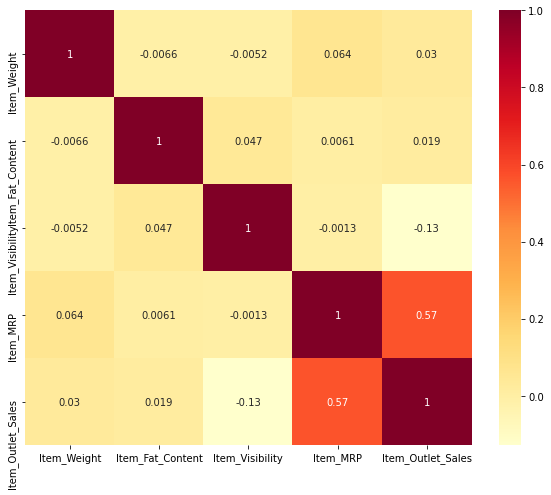

In [145]:
#Корреляция числовых данных. Видим, что наибольшее влияние оказывает Item_MRP - максимальная цена продукта
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))

data_int = data.drop(cat_feat, axis=1)
sns.heatmap(data_int.corr(), cmap = "YlOrRd", annot = True, fmt='.2g')

In [146]:
#Обрабатываем категориальные переменные
le = LabelEncoder()

for i  in cat_feat:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [197]:
data

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Item_Outlet_Sales,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,13.35,0,0.016047,4,249.8092,3735.1380,0,1,0,0,1,0,0
1,11.80,1,0.019278,14,48.2692,443.4228,0,1,0,0,0,1,0
2,12.35,0,0.016760,10,141.6180,2097.2700,0,1,0,0,1,0,0
3,13.10,1,0.000000,6,182.0950,732.3800,0,1,0,1,0,0,0
4,13.15,0,0.000000,9,53.8614,994.7052,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,13.15,0,0.056783,13,214.5218,2778.3834,1,0,0,0,1,0,0
8519,11.65,1,0.046982,0,108.1570,549.2850,1,0,0,0,1,0,0
8520,12.15,0,0.035186,8,85.1224,1193.1136,0,0,1,0,1,0,0
8521,13.15,1,0.145221,13,103.1332,1845.5976,0,1,0,0,0,1,0


In [148]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [198]:
y = data['Item_Outlet_Sales']
X = data.drop('Item_Outlet_Sales', axis = 1)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# делаем нормирование
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [200]:
#Линейная модель.
lin_reg = Lasso()

In [201]:
#Поиск оптимальных параметров линейной модели
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.]}
lasso_grid = GridSearchCV(lin_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [202]:
lasso_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [203]:
lasso_grit_best = lasso_grid.best_estimator_

In [204]:
y_pred_lasso = lasso_grit_best.predict(X_test)

In [205]:
#В качестве метрики качества выбрала RMSE (Корень из среднеквадратичной ошибки). Он выражается в тех же величинах, что и измеремая величина
#Качество линейной модели.
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(lasso_mse)
rmse_lasso

1154.686899297132

In [206]:
#Поиск оптимальных параметров нелинейной модели
clf_rf = RandomForestRegressor()
max_depth = [5, 9, 13, 15]
min_samples_split = [10, 15, 25]
param_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split}


clf_rf = GridSearchCV(clf_rf, param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 9, 13, 15],
   

In [207]:
clf_rf_best = clf_rf.best_estimator_
clf_rf_best

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=25,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [208]:
y_pred_rf = clf_rf.predict(X_test)

In [209]:
# Выводим важность признаков (TOP-5) 
importances = list(clf_rf_best.feature_importances_)
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(list(X.columns), importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: | {:20} | Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: | Item_MRP             | Importance: 0.55451
Variable: | Outlet_Type_Grocery Store | Importance: 0.31575
Variable: | Outlet_Type_Supermarket Type3 | Importance: 0.11954
Variable: | Outlet_Type_Supermarket Type1 | Importance: 0.00475
Variable: | Item_Weight          | Importance: 0.00227
Variable: | Item_Visibility      | Importance: 0.00139
Variable: | Outlet_Type_Supermarket Type2 | Importance: 0.00103
Variable: | Item_Type            | Importance: 0.00073
Variable: | Item_Fat_Content     | Importance: 2e-05
Variable: | Outlet_Size_Medium   | Importance: 1e-05
Variable: | Outlet_Size_Small    | Importance: 1e-05
Variable: | Outlet_Size_High     | Importance: 0.0


In [210]:
#Качество нелинейной модели
print(np.sqrt(mean_squared_error(y_test, y_pred_rf)))

1108.7983812191528


In [211]:
#Стекинг модели
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [212]:
lr = LinearRegression()
svr = SVR(kernel='linear')
lasso = Lasso(random_state = 1)
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

stregr = StackingRegressor(regressors=[svr, rf, lasso, gb], 
                           meta_regressor=lr)

stregr.fit(X_train, y_train)
stregr.predict(X_test)

for clf, label in zip([svr, rf, lasso, gb, stregr], 
                      ['LinearRegression',
                       'SVR',
                       'Lasso',
                       'GradBoosting',
                       'StackingRegressor']):

    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))


Accuracy: 0.52 (+/- 0.02) [LinearRegression]
Accuracy: 0.53 (+/- 0.03) [SVR]
Accuracy: 0.57 (+/- 0.03) [Lasso]
Accuracy: 0.60 (+/- 0.03) [GradBoosting]
Accuracy: 0.46 (+/- 0.04) [StackingRegressor]
